# Import Libraries

In [1]:
import argparse, os, sys, datetime, glob, importlib
from omegaconf import OmegaConf
import numpy as np
from PIL import Image
import torch
import torchvision
from torch.utils.data import random_split, DataLoader, Dataset
import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from pytorch_lightning.trainer import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, Callback, LearningRateMonitor
from pytorch_lightning.utilities import rank_zero_only

from taming.data.utils import custom_collate

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from taming.data.custom import CustomTest, CustomTestClariGAN
from torch.utils.data import DataLoader
import random
from tqdm import tqdm

import torch
import random
import torchvision.transforms.functional as F

# Helper Functions

In [3]:
def get_obj_from_str(string, reload=False):
    module, cls = string.rsplit(".", 1)
    if reload:
        module_imp = importlib.import_module(module)
        importlib.reload(module_imp)
    return getattr(importlib.import_module(module, package=None), cls)

def get_parser(**parser_kwargs):
    def str2bool(v):
        if isinstance(v, bool):
            return v
        if v.lower() in ("yes", "true", "t", "y", "1"):
            return True
        elif v.lower() in ("no", "false", "f", "n", "0"):
            return False
        else:
            raise argparse.ArgumentTypeError("Boolean value expected.")

    parser = argparse.ArgumentParser(**parser_kwargs)
    parser.add_argument(
        "-n",
        "--name",
        type=str,
        const=True,
        default="",
        nargs="?",
        help="postfix for logdir",
    )
    parser.add_argument(
        "-r",
        "--resume",
        type=str,
        const=True,
        default="",
        nargs="?",
        help="resume from logdir or checkpoint in logdir",
    )
    parser.add_argument(
        "-b",
        "--base",
        nargs="*",
        metavar="base_config.yaml",
        help="paths to base configs. Loaded from left-to-right. "
        "Parameters can be overwritten or added with command-line options of the form `--key value`.",
        default=list(),
    )
    parser.add_argument(
        "-t",
        "--train",
        type=str2bool,
        const=True,
        default=False,
        nargs="?",
        help="train",
    )
    parser.add_argument(
        "--no-test",
        type=str2bool,
        const=True,
        default=False,
        nargs="?",
        help="disable test",
    )
    parser.add_argument("-p", "--project", help="name of new or path to existing project")
    parser.add_argument(
        "-d",
        "--debug",
        type=str2bool,
        nargs="?",
        const=True,
        default=False,
        help="enable post-mortem debugging",
    )
    parser.add_argument(
        "-s",
        "--seed",
        type=int,
        default=23,
        help="seed for seed_everything",
    )
    parser.add_argument(
        "-f",
        "--postfix",
        type=str,
        default="",
        help="post-postfix for default name",
    )

    return parser

def nondefault_trainer_args(opt):
    parser = argparse.ArgumentParser()
    parser = Trainer.add_argparse_args(parser)
    args = parser.parse_args([])
    return sorted(k for k in vars(args) if getattr(opt, k) != getattr(args, k))

def instantiate_from_config(config):
    if not "target" in config:
        raise KeyError("Expected key `target` to instantiate.")
    return get_obj_from_str(config["target"])(**config.get("params", dict()))

In [4]:
# Function to denormalize and convert to numpy (if needed)
def tensor_to_numpy(image_tensor):
    """
    Convert a PyTorch tensor to a numpy array for visualization.
    Assumes image is in range [0, 1]. Modify if needed.
    """
    image_np = image_tensor.permute(1, 2, 0).cpu().numpy()  # (C, H, W) -> (H, W, C)
    return np.clip(image_np, 0, 1)

# Shift function
def apply_shift(image, max_shift_fraction=0.125):
    """
    Apply random translation (shift) to the image while zeroing out areas outside the input location.
    """
    _, _, H, W = image.shape
    max_shift_h = int(H * max_shift_fraction)
    max_shift_w = int(W * max_shift_fraction)

    # Random shifts
    shift_h = random.randint(-max_shift_h, max_shift_h)
    shift_w = random.randint(-max_shift_w, max_shift_w)

    # Apply affine transformation with translation
    return F.affine(image, angle=0, translate=(shift_w, shift_h), scale=1.0, shear=(0, 0), fill=0)

# Rotate function
def apply_rotation(image, max_angle=30):
    """
    Apply random rotation to the image while zeroing out areas outside the input location.
    """
    angle = random.uniform(-max_angle, max_angle)  # Random angle within [-max_angle, max_angle]

    # Apply rotation
    return F.rotate(image, angle, expand=False, fill=0)

# Crop function
def apply_crop(image, crop_fraction=0.25):
    """
    Apply random cropping to the image while zeroing out areas outside the original input location.
    """
    _, _, H, W = image.shape
    crop_h = int(H * crop_fraction)
    crop_w = int(W * crop_fraction)

    # Random crop position
    top = random.randint(0, H - crop_h)
    left = random.randint(0, W - crop_w)

    # Create a zero-padded tensor and fill in the cropped region
    cropped = torch.zeros_like(image)
    cropped[:, :, top:top + crop_h, left:left + crop_w] = image[:, :, top:top + crop_h, left:left + crop_w]
    return cropped

# Random augmentation function
def random_augmentations(image, enable_shift=True, enable_rotate=True, enable_crop=True):
    """
    Apply a random order of augmentations (shift, rotate, crop) to the image.
    """
    augmentations = []
    if enable_shift:
        augmentations.append(apply_shift)
    if enable_rotate:
        augmentations.append(apply_rotation)
    if enable_crop:
        augmentations.append(apply_crop)

    random.shuffle(augmentations)  # Shuffle the order of augmentations
    for augment in augmentations:
        image = augment(image)

    return image


# Define Model from Config

In [5]:
sys.argv = [
    "main.ipynb",  # Placeholder for script name
    "--base", r"C:\Users\ammic\Desktop\ClariGAN-DL\taming-transformers\configs\custom_vqgan_f16_imagenet.yaml",
]

In [6]:
if __name__ == "__main__":
    now = datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")

    # add cwd for convenience and to make classes in this file available when
    # running as `python main.py`
    # (in particular `main.DataModuleFromConfig`)
    sys.path.append(os.getcwd())

    parser = get_parser()
    parser = Trainer.add_argparse_args(parser)

    opt, unknown = parser.parse_known_args()

    seed_everything(opt.seed)


    # init and save configs
    configs = [OmegaConf.load(cfg) for cfg in opt.base]
    cli = OmegaConf.from_dotlist(unknown)
    config = OmegaConf.merge(*configs, cli)
    # model
    model = instantiate_from_config(config.model)


Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


c:\Users\ammic\anaconda3\envs\taming\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ammic\anaconda3\envs\taming\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips\vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


c:\Users\ammic\Desktop\ClariGAN-DL\taming-transformers\taming\modules\losses\lpips.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(ckpt,

# Define Test Dataloader and Load Weights

In [7]:
avg_rec_loss = []
plot = False
test_dataset = CustomTest(size=256, test_images_list_file=r"C:\Users\ammic\Desktop\ClariGAN-DL\xx_zproj_test_full.txt")
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

train_dataset = CustomTestClariGAN(size=256, test_images_list_file=r"C:\Users\ammic\Desktop\ClariGAN-DL\xx_zproj_train_full.txt")
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=0)

ckpt_path = r"C:\Users\ammic\Desktop\ClariGAN-DL\taming-transformers\logs\2025-02-02T14-00-16_clariGAN_finetune\checkpoints\epoch=000020.ckpt" # r"C:\Users\ammic\Desktop\ClariGAN-DL\taming-transformers\logs\2025-01-20T23-34-56_vqgan_imagenet_f16_16384_finetuned-full\checkpoints\epoch=000046.ckpt" # r"C:\Users\ammic\Desktop\ClariGAN-DL\taming-transformers\pretrained_weights\last.ckpt"
# ckpt_path = r"C:\Users\ammic\Desktop\ClariGAN-DL\taming-transformers\logs\2025-01-04T21-10-47_vqgan_imagenet_f16_16384_finetuned-microscopy\checkpoints\epoch=000015-val_rec_loss-val_loss=0.0000.ckpt"
model.init_from_ckpt(path=ckpt_path)
model.eval()

# Test dataloader loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

c:\Users\ammic\Desktop\ClariGAN-DL\taming-transformers\taming\models\vqgan.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd = torch.load(path, map_location="cpu")["st

Restored from C:\Users\ammic\Desktop\ClariGAN-DL\taming-transformers\logs\2025-02-02T14-00-16_clariGAN_finetune\checkpoints\epoch=000020.ckpt


VQModel(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down): ModuleList(
      (0-1): 2 x Module(
        (block): ModuleList(
          (0-1): 2 x ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
        (attn): ModuleList()
        (downsample): Downsample(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
        )
      )
      (2): Module(
        (block): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (no

# Original Test Set Results

In [8]:
for batch_idx, batch in tqdm(enumerate(test_dataloader)):
    inputs = batch["image"].to(device)  # Move data to the appropriate device


    inputs = inputs.permute((0,3,1,2))
    # print('inputs shape: ', inputs.shape)

    # Forward pass
    with torch.no_grad():
        outputs, recloss = model(inputs)
        
    avg_rec_loss.append(recloss.to('cpu'))
    # print('recloss: ', recloss)
    # print('outputs shape: ', outputs.shape)

    if plot == True:

        # Visualization
        batch_size = inputs.shape[0]

        outputs = (outputs + 1.0) / 2.0
        inputs = (inputs + 1.0) / 2.0

        # Create subplots
        if batch_size == 1:
            fig, axes = plt.subplots(1, 2, figsize=(6, 3))  # Single row, 2 columns for input and output
            axes = np.expand_dims(axes, axis=0)  # Expand to 2D array-like for consistent indexing
        else:
            fig, axes = plt.subplots(batch_size, 2, figsize=(6, 3 * batch_size))  # Rows for images

        for i in range(batch_size):
            # Convert tensors to numpy arrays
            input_image = tensor_to_numpy(inputs[i])
            output_image = tensor_to_numpy(outputs[i])

            # Display input (top)
            axes[i, 0].imshow(input_image)
            axes[i, 0].axis("off")
            axes[i, 0].set_title(f"Input {i+1}")

            # Display output (bottom)
            axes[i, 1].imshow(output_image)
            axes[i, 1].axis("off")
            axes[i, 1].set_title(f"Output {i+1}")

        # Adjust layout
        plt.tight_layout()
        plt.show()

print('Test set reconstruction loss average: ', np.mean(np.array(avg_rec_loss)))

299it [00:19, 19.35it/s]c:\Users\ammic\anaconda3\envs\taming\lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (132682365 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
303it [00:25,  1.17it/s]c:\Users\ammic\anaconda3\envs\taming\lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (109493478 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
304it [00:28, 10.83it/s]

Test set reconstruction loss average:  0.025333868


In [ ]:
# Test set reconstruction loss average:  0.027565222

# Visualize Latent Space Statistics

Processing: 395it [00:16, 32.45it/s]c:\Users\ammic\anaconda3\envs\taming\lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (89892448 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Processing: 696it [00:27, 33.37it/s]c:\Users\ammic\anaconda3\envs\taming\lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (97758648 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Processing: 704it [00:35, 19.73it/s]
Processing: 298it [00:13, 30.76it/s]c:\Users\ammic\anaconda3\envs\taming\lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (132682365 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Processing: 302it [00:15,  4.55it/s]c:\Users\ammic\anaconda3\envs\taming\lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (109493478 pixels) exceeds limit of 89478485 pi

Train Latent Shape: (704, 65536)
Test Latent Shape: (304, 65536)


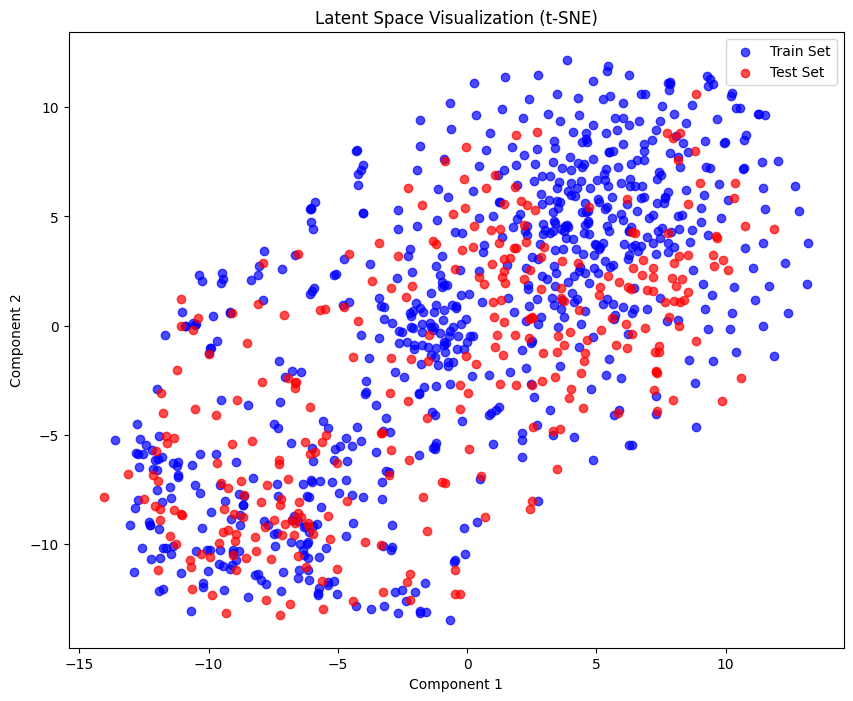

In [9]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Function to extract and flatten latent representations
def extract_latent_representations(dataloader, model, device):
    latent_representations = []
    with torch.no_grad():
        for batch_idx, batch in tqdm(enumerate(dataloader), desc="Processing"):
            inputs = batch["image"].to(device)  # Move data to device
            inputs = inputs.permute((0, 3, 1, 2))  # Adjust to channel-first format
            quant, _, _ = model.encode(inputs)  # Get the latent representation
            batch_latent = quant.view(quant.size(0), -1).cpu().numpy()  # Flatten to [batch_size, latent_dim]
            latent_representations.append(batch_latent)
    return np.concatenate(latent_representations, axis=0)

# Ensure the model is in evaluation mode
model.eval()

# Extract latent representations for training and test sets
train_latent_representations = extract_latent_representations(train_dataloader, model, device)
test_latent_representations = extract_latent_representations(test_dataloader, model, device)

print(f"Train Latent Shape: {train_latent_representations.shape}")
print(f"Test Latent Shape: {test_latent_representations.shape}")

# Concatenate training and test latent representations for joint t-SNE
combined_latent_representations = np.concatenate([train_latent_representations, test_latent_representations], axis=0)

# Perform t-SNE on the concatenated latent representations
reduced_latent = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(combined_latent_representations)

# Split reduced_latent back into train and test sets
num_train = len(train_latent_representations)
reduced_train_latent = reduced_latent[:num_train]
reduced_test_latent = reduced_latent[num_train:]

# Visualization
plt.figure(figsize=(10, 8))

# Plot training set in blue
plt.scatter(reduced_train_latent[:, 0], reduced_train_latent[:, 1], alpha=0.7, label="Train Set", color="blue")

# Plot test set in red
plt.scatter(reduced_test_latent[:, 0], reduced_test_latent[:, 1], alpha=0.7, label="Test Set", color="red")

# Add titles and legends
plt.title("Latent Space Visualization (t-SNE)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.show()


# Visualise Samples

Processing: 394it [00:15, 32.38it/s]c:\Users\ammic\anaconda3\envs\taming\lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (89892448 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Processing: 696it [00:27, 33.46it/s]c:\Users\ammic\anaconda3\envs\taming\lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (97758648 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Processing: 704it [00:35, 19.94it/s]
Processing: 298it [00:13, 30.59it/s]c:\Users\ammic\anaconda3\envs\taming\lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (132682365 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Processing: 302it [00:16,  4.45it/s]c:\Users\ammic\anaconda3\envs\taming\lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (109493478 pixels) exceeds limit of 89478485 pi

Train Latent Shape: (704, 65536)
Test Latent Shape: (304, 65536)


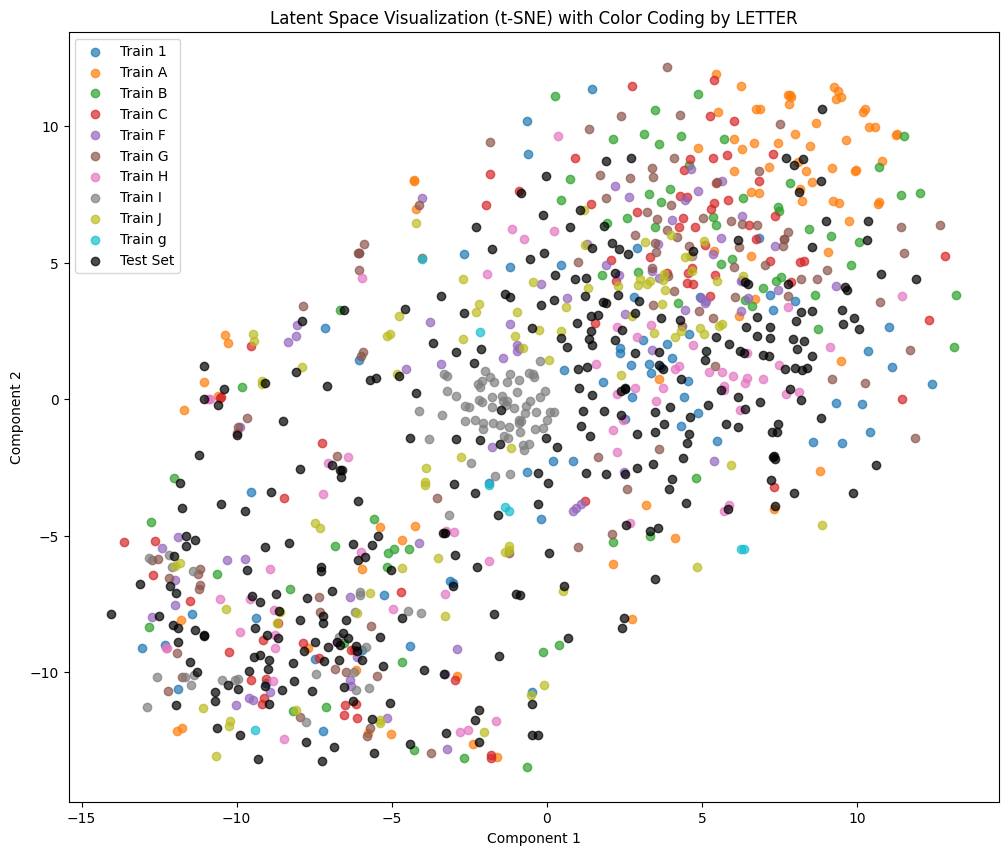

In [10]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import matplotlib.cm as cm

# Function to extract and flatten latent representations
def extract_latent_representations(dataloader, model, device, has_paths=False):
    latent_representations = []
    paths = [] if has_paths else None
    with torch.no_grad():
        for batch_idx, batch in tqdm(enumerate(dataloader), desc="Processing"):
            inputs = batch["image"].to(device)  # Move data to device
            inputs = inputs.permute((0, 3, 1, 2))  # Adjust to channel-first format
            quant, _, _ = model.encode(inputs)  # Get the latent representation
            batch_latent = quant.view(quant.size(0), -1).cpu().numpy()  # Flatten to [batch_size, latent_dim]
            latent_representations.append(batch_latent)
            if has_paths:
                paths.extend(dataloader.dataset.paths[batch_idx * inputs.shape[0]:(batch_idx + 1) * inputs.shape[0]])
    return np.concatenate(latent_representations, axis=0), paths

# Extract `LETTER` from paths
def extract_letter_from_path(path):
    """Extracts the `LETTER` from a given path."""
    return path.split("\\")[-1].split("_")[0][-1]

# Ensure the model is in evaluation mode
model.eval()

# Extract latent representations and paths for the training set
train_latent_representations, train_paths = extract_latent_representations(train_dataloader, model, device, has_paths=True)

# Extract latent representations for the test set (no paths)
test_latent_representations, _ = extract_latent_representations(test_dataloader, model, device, has_paths=False)

print(f"Train Latent Shape: {train_latent_representations.shape}")
print(f"Test Latent Shape: {test_latent_representations.shape}")

# Extract LETTERs and assign colors
train_letters = [extract_letter_from_path(path) for path in train_paths]
unique_letters = sorted(set(train_letters))
letter_to_color = {letter: cm.tab10(i / len(unique_letters)) for i, letter in enumerate(unique_letters)}
train_colors = [letter_to_color[letter] for letter in train_letters]

# Perform t-SNE on the concatenated latent representations
combined_latent_representations = np.concatenate([train_latent_representations, test_latent_representations], axis=0)
reduced_latent = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(combined_latent_representations)

# Split reduced_latent back into train and test sets
num_train = len(train_latent_representations)
reduced_train_latent = reduced_latent[:num_train]
reduced_test_latent = reduced_latent[num_train:]

# Visualization
plt.figure(figsize=(12, 10))

# Plot training set with different colors for each LETTER
for letter in unique_letters:
    letter_indices = [i for i, l in enumerate(train_letters) if l == letter]
    plt.scatter(
        reduced_train_latent[letter_indices, 0],
        reduced_train_latent[letter_indices, 1],
        alpha=0.7,
        label=f"Train {letter}",
        color=letter_to_color[letter],
    )

# Plot test set in black
plt.scatter(reduced_test_latent[:, 0], reduced_test_latent[:, 1], alpha=0.7, label="Test Set", color="black")

# Add titles, legends, and labels
plt.title("Latent Space Visualization (t-SNE) with Color Coding by LETTER")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.show()

Processing Test Set: 2it [00:00,  4.57it/s]

Selected Latent Pixels: [(102, 2, 5), (179, 6, 4), (92, 10, 1), (14, 10, 7), (106, 7, 11), (71, 4, 13), (188, 3, 5), (20, 7, 1), (102, 7, 15), (121, 2, 11)]


Processing Test Set: 298it [00:13, 30.36it/s]c:\Users\ammic\anaconda3\envs\taming\lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (132682365 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Processing Test Set: 302it [00:15,  4.47it/s]c:\Users\ammic\anaconda3\envs\taming\lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (109493478 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Processing Test Set: 304it [00:18, 16.52it/s]


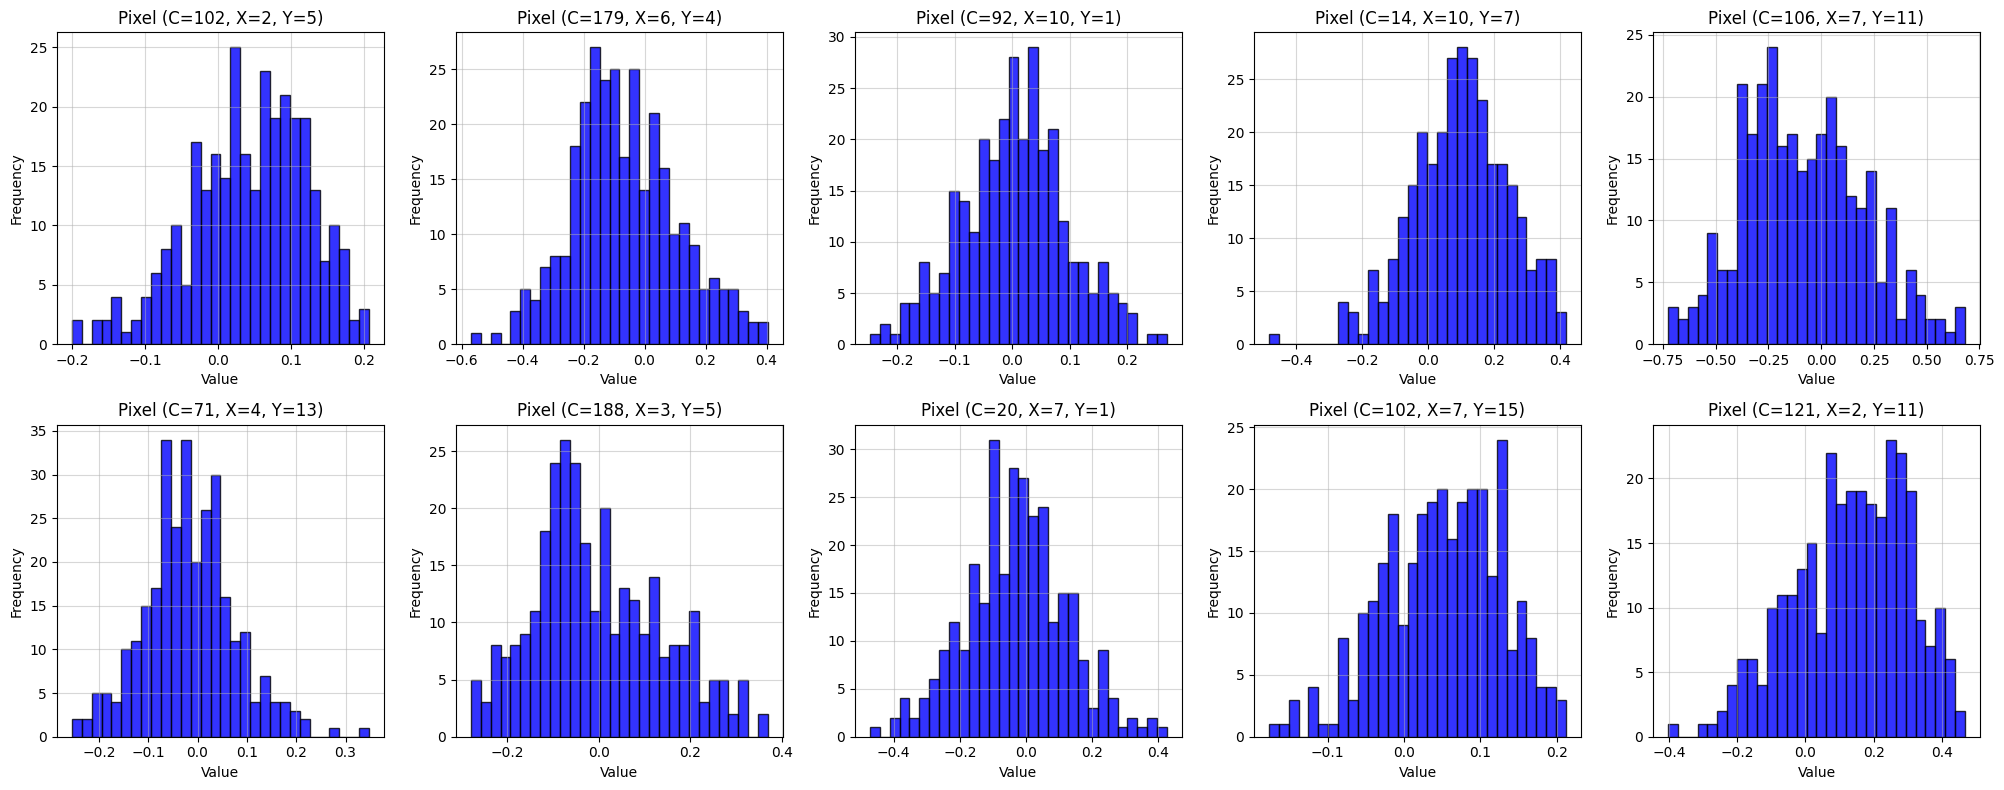

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set random seed for reproducibility
np.random.seed(42)

# Ensure the model is in evaluation mode
model.eval()

# Placeholder for latent pixel values of multiple random pixels
latent_pixel_values = []

# Forward pass through the test set
with torch.no_grad():
    for batch_idx, batch in tqdm(enumerate(test_dataloader), desc="Processing Test Set"):
        inputs = batch["image"].to(device)  # Move data to device
        inputs = inputs.permute((0, 3, 1, 2))  # Adjust to channel-first format
        quant, _, _ = model.encode(inputs)  # Get the latent representation

        quant = quant - quant.min()
        quant = quant / quant.max()
        quant = 2.0*quant - 1.0

        if not latent_pixel_values:  # Initialize pixel placeholders on the first batch
            num_pixels = 10  # Total number of random pixels to visualize
            channels = np.random.randint(0, quant.shape[1], size=num_pixels)
            xs = np.random.randint(0, quant.shape[2], size=num_pixels)
            ys = np.random.randint(0, quant.shape[3], size=num_pixels)
            latent_pixel_values = [[] for _ in range(num_pixels)]
            print(f"Selected Latent Pixels: {list(zip(channels, xs, ys))}")

        # Extract values for the random pixels
        for i, (c, x, y) in enumerate(zip(channels, xs, ys)):
            batch_pixel_values = quant[:, c, x, y].cpu().numpy()
            latent_pixel_values[i].extend(batch_pixel_values)

# Visualization: Grid of histograms
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.ravel()  # Flatten the 2D grid of axes into a 1D array for easier indexing

for i, ax in enumerate(axes):
    pixel_values = np.array(latent_pixel_values[i])
    ax.hist(pixel_values, bins=30, alpha=0.8, color="blue", edgecolor="black")
    ax.set_title(f"Pixel (C={channels[i]}, X={xs[i]}, Y={ys[i]})")
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")
    ax.grid(alpha=0.5)

plt.tight_layout()
plt.show()

In [12]:
# Ensure the model is in evaluation mode
model.eval()

# Forward pass through the test set
with torch.no_grad():
    for batch_idx, batch in enumerate(test_dataloader):
        inputs = batch["image"].to(device)  # Move data to device
        inputs = inputs.permute((0,3,1,2))

        quant, _, _ = model.encode(inputs)  # Get the latent representation
        
        # Print shape of the latent representation for the current batch
        print(f"Batch {batch_idx + 1} - Latent Shape: {quant.shape}")
        break

Batch 1 - Latent Shape: torch.Size([1, 256, 16, 16])


# Visualize Augmented Test Set Results

In [13]:
def plot_inputs(inputs, title):
    inputs = (inputs + 1.0) / 2.0
    plt.imshow(inputs[0].permute(1,2,0).cpu())
    plt.title(title)
    plt.show()

Batch 1 - inputs shape before augmentation: torch.Size([1, 3, 256, 256])


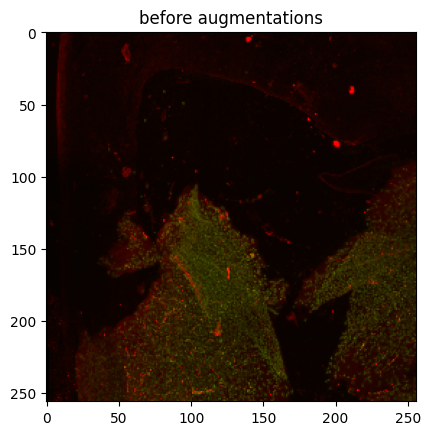

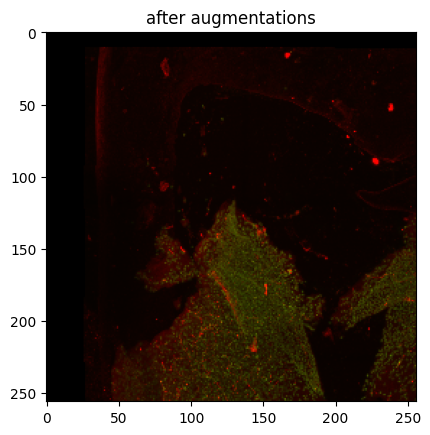

Batch 1 - inputs shape after augmentation: torch.Size([1, 3, 256, 256])
Reconstruction loss: 0.03005172125995159
Outputs shape: torch.Size([1, 3, 256, 256])


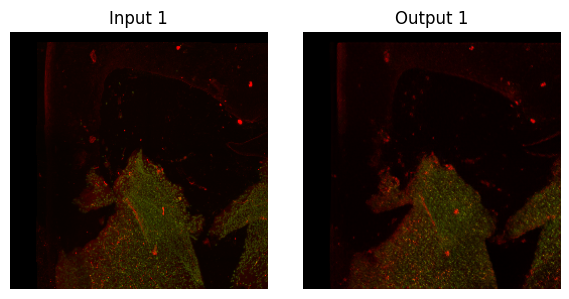

Batch 2 - inputs shape before augmentation: torch.Size([1, 3, 256, 256])


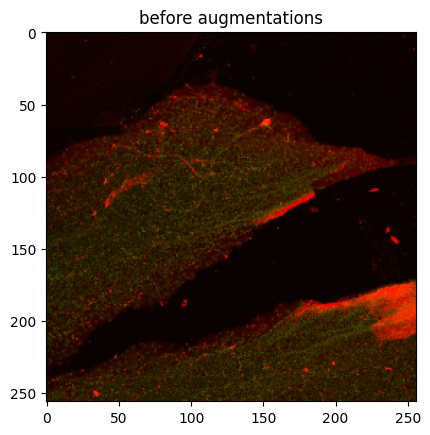

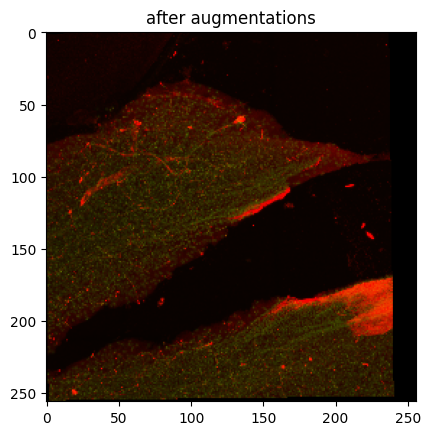

Batch 2 - inputs shape after augmentation: torch.Size([1, 3, 256, 256])
Reconstruction loss: 0.031408943235874176
Outputs shape: torch.Size([1, 3, 256, 256])


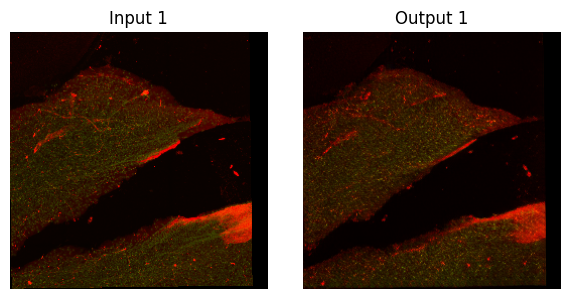

Batch 3 - inputs shape before augmentation: torch.Size([1, 3, 256, 256])


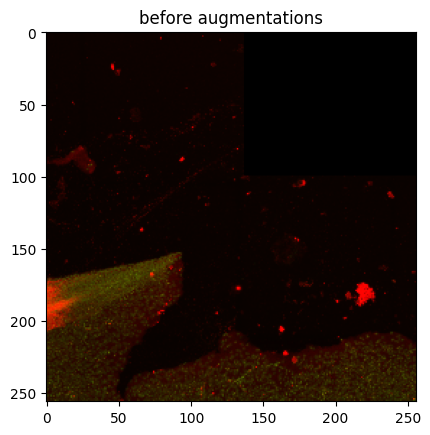

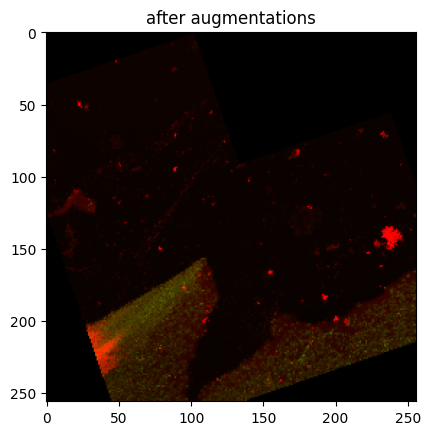

Batch 3 - inputs shape after augmentation: torch.Size([1, 3, 256, 256])
Reconstruction loss: 0.030048910528421402
Outputs shape: torch.Size([1, 3, 256, 256])


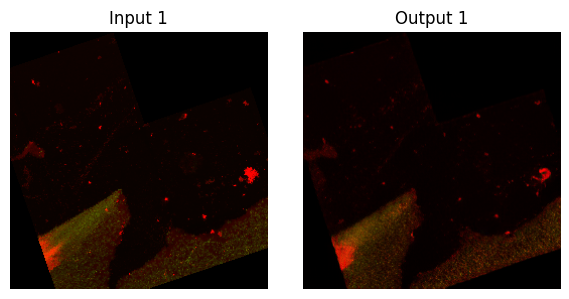

Batch 4 - inputs shape before augmentation: torch.Size([1, 3, 256, 256])


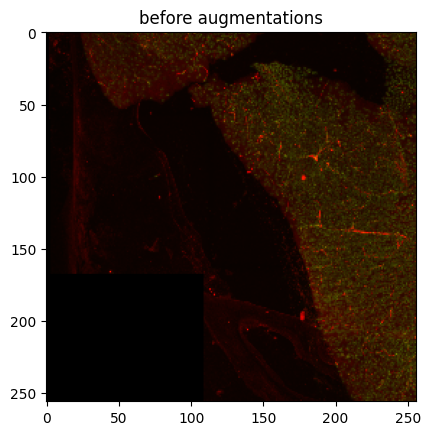

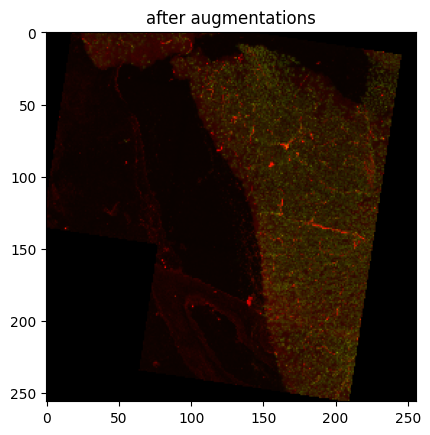

Batch 4 - inputs shape after augmentation: torch.Size([1, 3, 256, 256])
Reconstruction loss: 0.026627756655216217
Outputs shape: torch.Size([1, 3, 256, 256])


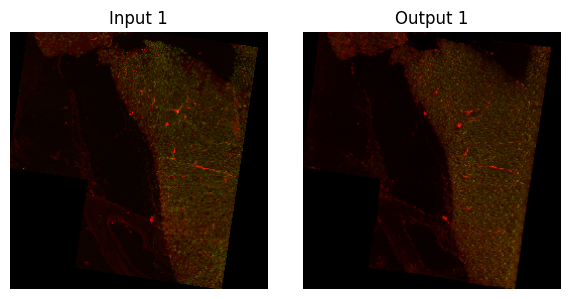

Batch 5 - inputs shape before augmentation: torch.Size([1, 3, 256, 256])


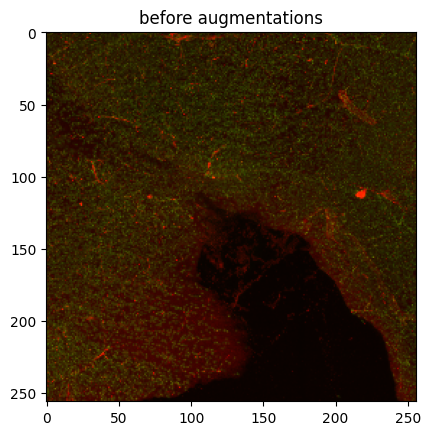

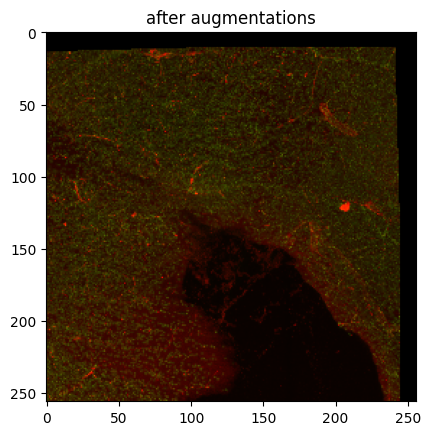

Batch 5 - inputs shape after augmentation: torch.Size([1, 3, 256, 256])
Reconstruction loss: 0.026893792673945427
Outputs shape: torch.Size([1, 3, 256, 256])


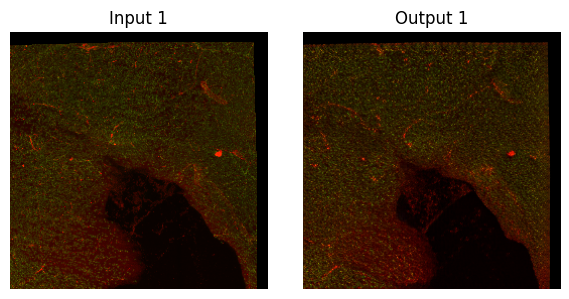

Batch 6 - inputs shape before augmentation: torch.Size([1, 3, 256, 256])


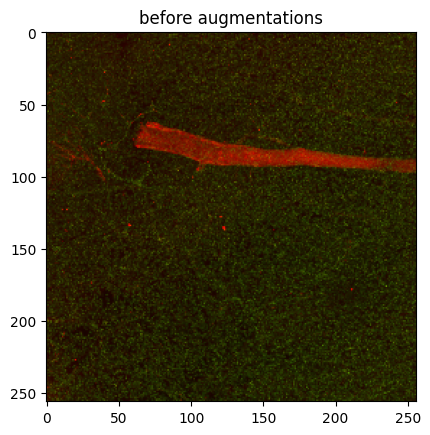

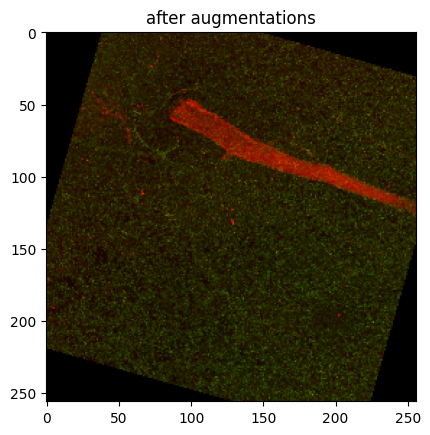

Batch 6 - inputs shape after augmentation: torch.Size([1, 3, 256, 256])
Reconstruction loss: 0.02551133930683136
Outputs shape: torch.Size([1, 3, 256, 256])


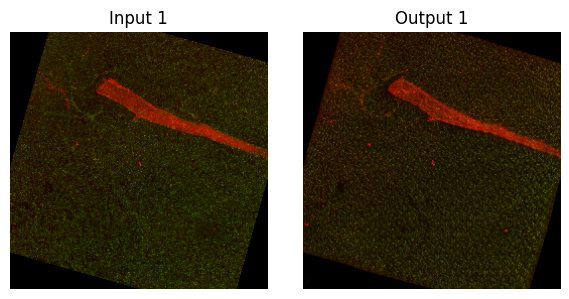

Batch 7 - inputs shape before augmentation: torch.Size([1, 3, 256, 256])


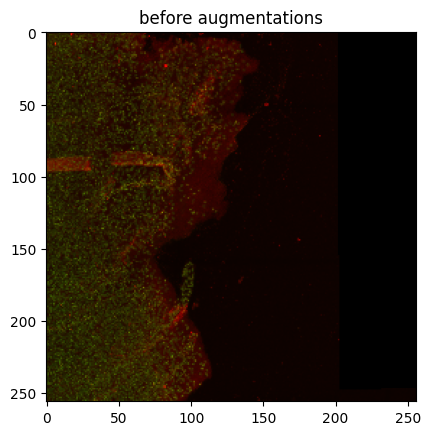

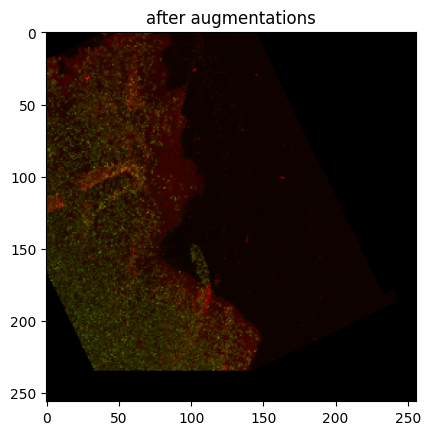

Batch 7 - inputs shape after augmentation: torch.Size([1, 3, 256, 256])
Reconstruction loss: 0.023571379482746124
Outputs shape: torch.Size([1, 3, 256, 256])


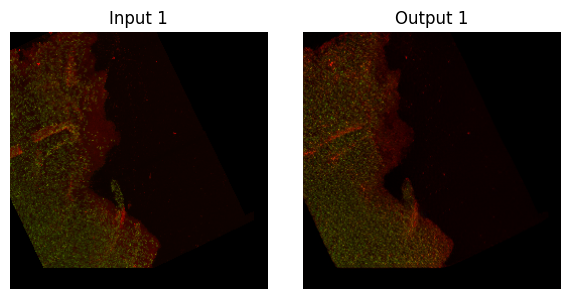

Batch 8 - inputs shape before augmentation: torch.Size([1, 3, 256, 256])


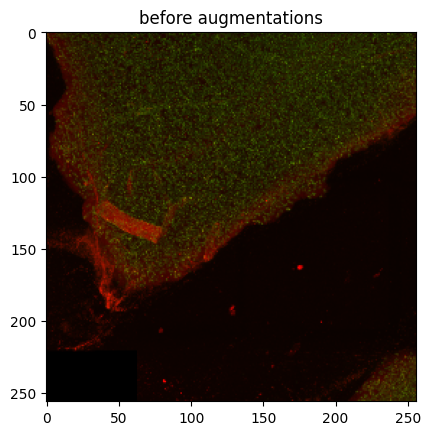

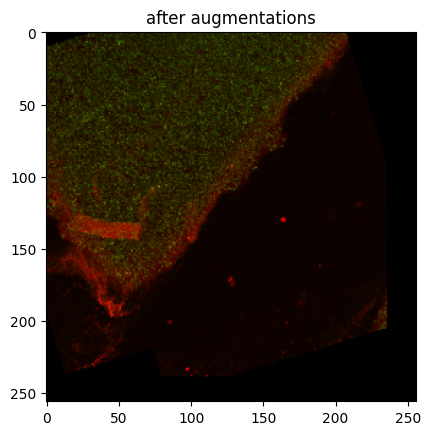

Batch 8 - inputs shape after augmentation: torch.Size([1, 3, 256, 256])
Reconstruction loss: 0.02702208049595356
Outputs shape: torch.Size([1, 3, 256, 256])


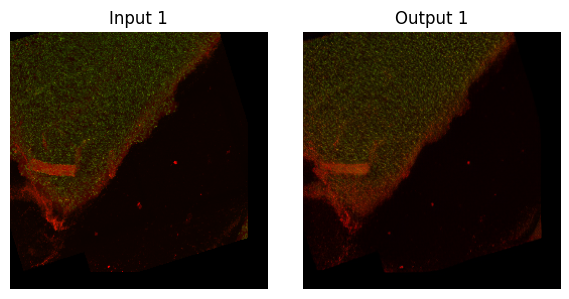

Batch 9 - inputs shape before augmentation: torch.Size([1, 3, 256, 256])


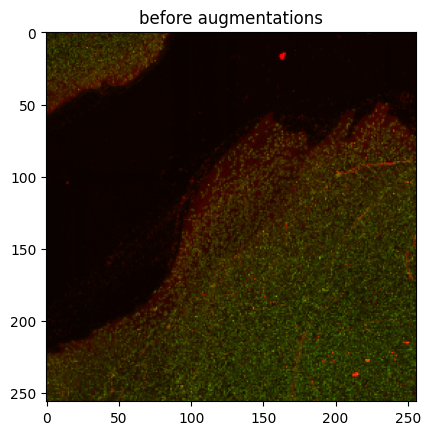

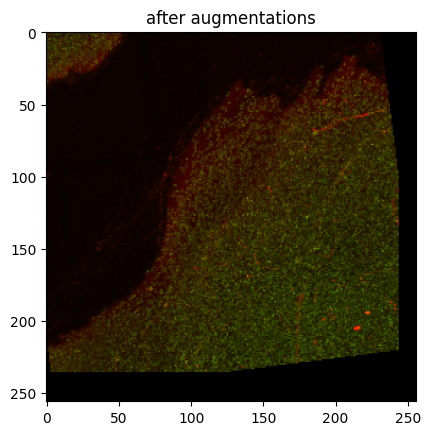

Batch 9 - inputs shape after augmentation: torch.Size([1, 3, 256, 256])
Reconstruction loss: 0.025482764467597008
Outputs shape: torch.Size([1, 3, 256, 256])


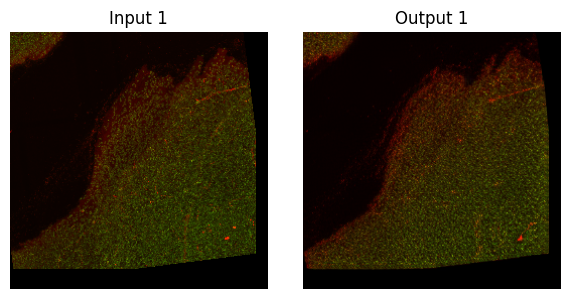

Batch 10 - inputs shape before augmentation: torch.Size([1, 3, 256, 256])


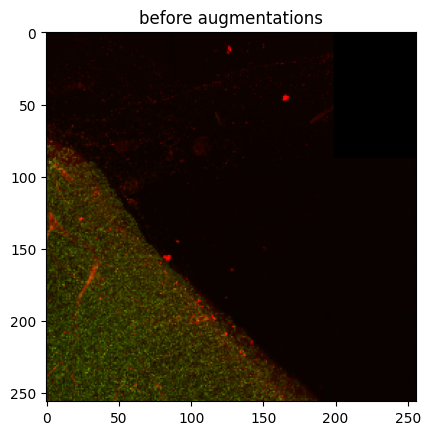

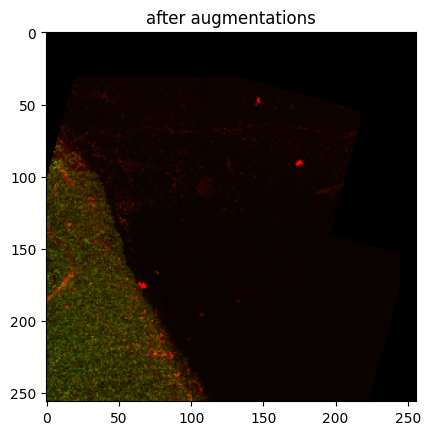

Batch 10 - inputs shape after augmentation: torch.Size([1, 3, 256, 256])
Reconstruction loss: 0.025826329365372658
Outputs shape: torch.Size([1, 3, 256, 256])


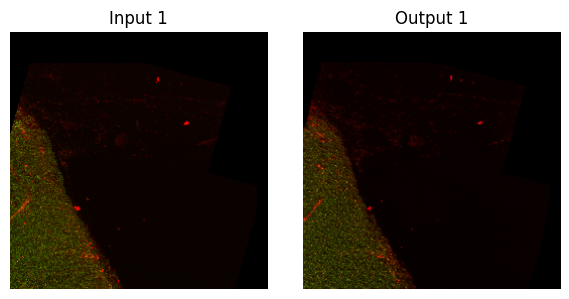

Batch 11 - inputs shape before augmentation: torch.Size([1, 3, 256, 256])


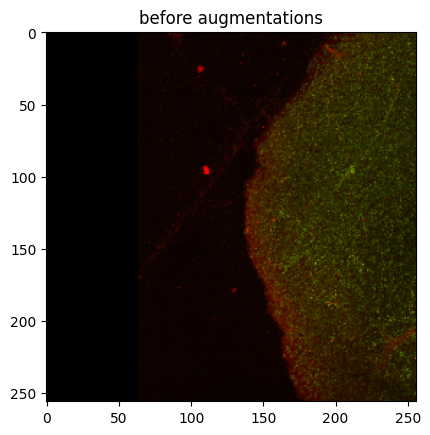

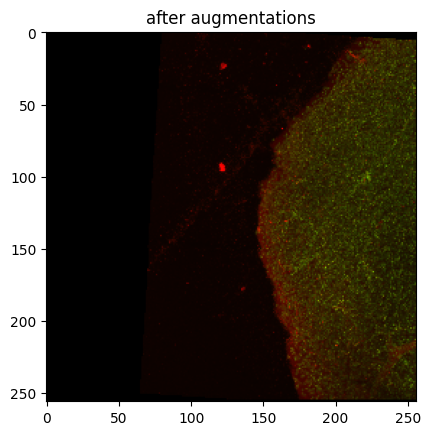

Batch 11 - inputs shape after augmentation: torch.Size([1, 3, 256, 256])
Reconstruction loss: 0.022597074508666992
Outputs shape: torch.Size([1, 3, 256, 256])


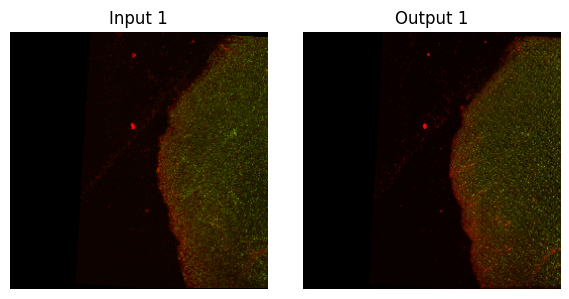

In [14]:
# Test loop for inference and visualization
for batch_idx, batch in enumerate(test_dataloader):
    inputs = batch["image"].to(device)  # Move data to device
    inputs = inputs.permute((0, 3, 1, 2))  # (B, H, W, C) -> (B, C, H, W)
    print(f"Batch {batch_idx + 1} - inputs shape before augmentation: {inputs.shape}")

    # Apply random augmentations
    plot_inputs(inputs, title='before augmentations')
    inputs = (inputs + 1.0) / 2.0
    inputs = random_augmentations(inputs, enable_shift=True, enable_rotate=True, enable_crop=False)
    inputs = 2.0*inputs - 1.0


    plot_inputs(inputs, title='after augmentations')
    print(f"Batch {batch_idx + 1} - inputs shape after augmentation: {inputs.shape}")
    
    # Forward pass
    with torch.no_grad():
        outputs, recloss = model(inputs)

    print(f"Reconstruction loss: {recloss}")
    print(f"Outputs shape: {outputs.shape}")

    # Normalize for visualization
    outputs = (outputs + 1.0) / 2.0
    inputs = (inputs + 1.0) / 2.0

    # Visualization
    batch_size = inputs.shape[0]
    fig, axes = plt.subplots(batch_size, 2, figsize=(6, 3 * batch_size))
    if batch_size == 1:
        axes = np.expand_dims(axes, axis=0)  # Ensure consistent indexing for single batch

    for i in range(batch_size):
        # Convert tensors to numpy arrays
        input_image = tensor_to_numpy(inputs[i])
        output_image = tensor_to_numpy(outputs[i])

        # Display input
        axes[i, 0].imshow(input_image)
        axes[i, 0].axis("off")
        axes[i, 0].set_title(f"Input {i + 1}")

        # Display output
        axes[i, 1].imshow(output_image)
        axes[i, 1].axis("off")
        axes[i, 1].set_title(f"Output {i + 1}")

    # Adjust layout and show the visualization
    plt.tight_layout()
    plt.show()
    if(batch_idx == 10):
        break

# Save latent representation of sample

In [15]:
# Test loop for inference and visualization
for batch_idx, batch in enumerate(test_dataloader):
    inputs = batch["image"].to(device)  # Move data to device
    inputs = inputs.permute((0, 3, 1, 2))  # (B, H, W, C) -> (B, C, H, W)

    print(f"Batch {batch_idx + 1} - inputs shape: {inputs.shape}")

    
    # Forward pass
    with torch.no_grad():
        quant, diff, _ = model.encode(inputs)

    print(f"quant shape: {quant.shape}")
    print(f"Diff: {diff}")

    torch.save(quant, r"C:\Users\ammic\Desktop\ClariGAN-DL\taming-transformers\vqgan_imagenet_f16_example_latent\example_latent.pt")    
    break

Batch 1 - inputs shape: torch.Size([1, 3, 256, 256])
quant shape: torch.Size([1, 256, 16, 16])
Diff: 0.03155579790472984


# Compare Latents

In [16]:
# Test loop for inference and visualization
for batch_idx, batch in enumerate(test_dataloader):
    inputs = batch["image"].to(device)  # Move data to device
    inputs = inputs.permute((0, 3, 1, 2))  # (B, H, W, C) -> (B, C, H, W)

    print(f"Batch {batch_idx + 1} - inputs shape: {inputs.shape}")

    
    # Forward pass
    with torch.no_grad():
        quant, diff, _ = model.encode(inputs)

    print(f"quant shape: {quant.shape}")
    print(f"Diff: {diff}")

    quant_comp = torch.load(r"C:\Users\ammic\Desktop\ClariGAN-DL\taming-transformers\vqgan_imagenet_f16_example_latent\example_latent.pt") 

    print("Is equal? ", torch.equal(quant, quant_comp))
    break

Batch 1 - inputs shape: torch.Size([1, 3, 256, 256])
quant shape: torch.Size([1, 256, 16, 16])
Diff: 0.03155579790472984
Is equal?  True


C:\Users\ammic\AppData\Local\Temp\ipykernel_2056\3548428065.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  quant_comp = torch.load(r"C:\Users\ammic\Desktop\ClariGAN-DL

In [17]:
# Test loop for inference and visualization
for batch_idx, batch in enumerate(test_dataloader):
    inputs = batch["image"].to(device)  # Move data to device
    inputs = inputs.permute((0, 3, 1, 2))  # (B, H, W, C) -> (B, C, H, W)

    print(f"Batch {batch_idx + 1} - inputs shape: {inputs.shape}")

    
    # Forward pass
    with torch.no_grad():
        quant, diff, _ = model.encode(inputs)

    print(f"quant shape: {quant.shape}")
    print(f"Diff: {diff}")

    quant_comp = torch.load(r"C:\Users\ammic\Desktop\ClariGAN-DL\taming-transformers\vqgan_imagenet_f16_example_latent\example_latent.pt") 

    print("Is equal? ", torch.equal(quant, quant_comp))
    break

Batch 1 - inputs shape: torch.Size([1, 3, 256, 256])
quant shape: torch.Size([1, 256, 16, 16])
Diff: 0.03155579790472984
Is equal?  True


C:\Users\ammic\AppData\Local\Temp\ipykernel_2056\3548428065.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  quant_comp = torch.load(r"C:\Users\ammic\Desktop\ClariGAN-DL